In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/RL_Games_Minesweeper')


In [3]:
!pip install pygame
!pip install mss

     |████████████████████████████████| 11.4MB 254kB/s 
     |████████████████████████████████| 81kB 2.4MB/s 


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gym
import collections
import numpy as np

from tensorflow.keras import optimizers
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")


In [5]:

from minesweeper_pygame import Minesweeper
env = Minesweeper(display=False, ROWS = 6, COLS = 6, MINES = 4,OUT='CONDENSED', rewards = {"win" : 1, "loss" : -1, "progress" : 0.9, "noprogress" : -0.3, "YOLO" : -0.3})
min_state = env.stateConverter(env.get_state()).flatten()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
RANDOM_SEED=1
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
def get_winrate(env,actor):
    games = 0
    moves = 0
    stuck = 0
    won_games = 0
    lost_games = 0
    r = 0
    while games < 10000:
        while True:
            state = env.stateConverter(env.get_state())

            action_probs = actor.predict(np.array([state]))
            action_probs=action_probs.ravel()

            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            moves += 1

            if reward == 1:
                won_games += 1
            if reward == -1:
                lost_games += 1

            if done:
                games += 1
                env.reset()
                moves = 0
                break
            elif moves >= 30:
                stuck += 1
                games += 1
                
                lost_games +=1
                env.reset()
                moves = 0
                break
    return(won_games/games)


In [8]:
#Note: The advantage here is the total rewards. Hence, y_true during train_on_batch has magnitude of the total rewards!
# I have added an extra 1 with y_pred so that the loss does not go to infinity and to avoid NaN error
def custom_loss(y_true,y_pred):
        loss =  -tf.reduce_mean(y_true*tf.math.log(y_pred+1))
        return loss


In [9]:
def PolicyEstimator(env,lr=0.0001):
  # Neural network
  n_inputs=env.stateConverter(env.get_state()).shape
  n_hidden = 288
  n_hidden2 = 220
  n_hidden3 = 200
  n_outputs = env.ROWS*env.COLS


  model = Sequential()

  model.add(Conv2D(18, kernel_size=(5, 5), strides=(1, 1),kernel_initializer=glorot_normal(), activation='relu',padding='same', input_shape=n_inputs))
  model.add(Conv2D(36, kernel_size=(3, 3), strides=(1, 1),kernel_initializer=glorot_normal(),activation='relu', padding='same'))
  model.add(Flatten())
  model.add(Dense(n_hidden, activation='relu'))
  model.add(Dense(n_hidden2, activation='relu'))
  model.add(Dense(n_hidden3, activation='relu'))

  model.add(Dense(n_outputs, activation='softmax'))

  model.compile(loss=custom_loss, optimizer=Adam(learning_rate=lr))

  print(model.summary())

  return model


In [10]:
def ValueEstimator(env,lr=0.0001):
  # Neural network
  n_inputs=env.stateConverter(env.get_state()).shape
  n_hidden = 288
  n_hidden2 = 220
  n_hidden3 = 200


  model = Sequential()

  model.add(Conv2D(18, kernel_size=(5, 5), strides=(1, 1),kernel_initializer=glorot_normal(), activation='relu',padding='same', input_shape=n_inputs))
  model.add(Conv2D(36, kernel_size=(3, 3), strides=(1, 1),kernel_initializer=glorot_normal(),activation='relu', padding='same'))
  model.add(Flatten())
  model.add(Dense(n_hidden, activation='relu'))
  model.add(Dense(n_hidden2, activation='relu'))
  model.add(Dense(n_hidden3, activation='relu'))

  model.add(Dense(1, activation=None))

  model.compile(loss='mse', optimizer=Adam(learning_rate=lr))

  print(model.summary())

  return model


In [11]:
def A2C(env,lr=0.0001,num_episodes=5000,discount_factor=0.99):

    actor = PolicyEstimator(env,lr)
    critic=ValueEstimator(env,lr)

    wins=0

    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    episode_lengths=np.zeros(num_episodes)
    episode_rewards=np.zeros(num_episodes)



    for game in range(num_episodes):

        done = False
        env.reset()
        state= env.stateConverter(env.get_state())

        episode = []
        t_step=0

        states, actions, rewards = [], [], []

        recorded_return =0
        while not done and t_step<6*6:
            t_step += 1


            action_probs = actor.predict(np.array([state]))
            action_probs=action_probs.ravel()

            # print(action_probs)


            if np.isnan(action_probs).any():
              break


            # for i in range(len(action_probs)):
            #   if i not in env.action_space():
            #     action_probs[i]=0
              
            # action_probs/=sum(action_probs)

            


            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            recorded_return= recorded_return + reward



            
            value_next = critic.predict(np.array([next_state]))
            critic_target=reward + discount_factor*value_next
            advantage=critic_target - critic.predict(np.array([state]))


            one_hot_output = np.zeros(env.ROWS*env.COLS)
            one_hot_output[action] = advantage + 1e-5

            critic.train_on_batch(np.array([state]),critic_target)

            actor.train_on_batch( np.array([state]), np.expand_dims(one_hot_output,axis=0))


            state = next_state
            


        print('episode:',(game+1),'score:',(recorded_return),'timesteps:',(t_step))

        episode_rewards[game] += recorded_return
        episode_lengths[game] = t_step

        if game%100000==0:

          actor.save('/content/gdrive/My Drive/Colab Notebooks/RL_Games_Minesweeper/Models/A2C_v2.h5')
          critic.save('/content/gdrive/My Drive/Colab Notebooks/RL_Games_Minesweeper/Models/A2C_value.h5')





    wins=get_winrate(env,actor)
    print('win_rate=')
    print(wins*100)

    actor.save('/content/gdrive/My Drive/Colab Notebooks/RL_Games_Minesweeper/Models/A2C_v2.h5')


    plt.figure(figsize=(10,6))
    plt.subplot(211)
    plt.plot(episode_rewards)
    plt.xlabel('episodes'); plt.ylabel('rewards')
    plt.xlim((0, len(episode_rewards)))
    plt.legend(loc=1); plt.grid()
    plt.subplot(212)
    plt.plot(episode_lengths)
    plt.xlabel('episodes'); plt.ylabel('time_steps')
    plt.xlim((0, len(episode_lengths)))
    plt.legend(loc=4); plt.grid()
    plt.tight_layout(); plt.show()

    return actor
         


Streaming output truncated to the last 5000 lines.
episode: 395002 score: 2.8 timesteps: 3
episode: 395003 score: 0.10000000000000075 timesteps: 32
episode: 395004 score: 10.900000000000002 timesteps: 12
episode: 395005 score: 7.300000000000001 timesteps: 8
episode: 395006 score: 10.900000000000002 timesteps: 12
episode: 395007 score: 6.4 timesteps: 7
episode: 395008 score: 8.200000000000001 timesteps: 9
episode: 395009 score: 6.4 timesteps: 7
episode: 395010 score: 10.000000000000002 timesteps: 11
episode: 395011 score: 4.6 timesteps: 5
episode: 395012 score: 6.4 timesteps: 7
episode: 395013 score: 3.5 timesteps: 6
episode: 395014 score: 2.6 timesteps: 5
episode: 395015 score: 7.300000000000001 timesteps: 8
episode: 395016 score: 9.100000000000001 timesteps: 10
episode: 395017 score: -2.2 timesteps: 5
episode: 395018 score: 1.9 timesteps: 2
episode: 395019 score: 8.8 timesteps: 11
episode: 395020 score: 10.900000000000002 timesteps: 12
episode: 395021 score: 5.5 timesteps: 6
episode: 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


win_rate=
90.98


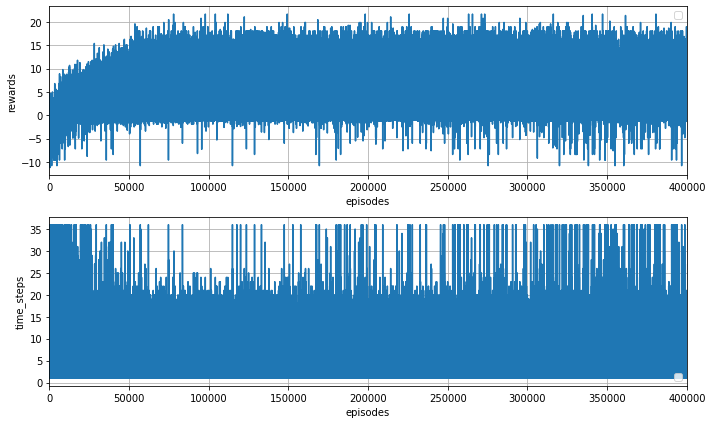

In [12]:
%time
agent = A2C(env,num_episodes=400000)

In [13]:
model = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/RL_Games_Minesweeper/Models/A2C_v2.h5",custom_objects={'custom_loss':custom_loss})

get_winrate(env,model)

0.9059